In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import modelos as md
from importlib import reload
reload(md)

<module 'modelos' from 'd:\\rodri\\Programações\\Aprendizado de Maquina\\Reconhecimento-de-digitos-ML-2023.2\\modelos.py'>

In [2]:
dataframe_treino = pd.read_csv('train_reduzido_1_5.csv', sep=';')
dataframe_teste = pd.read_csv('test_reduzido_1_5.csv', sep=';')

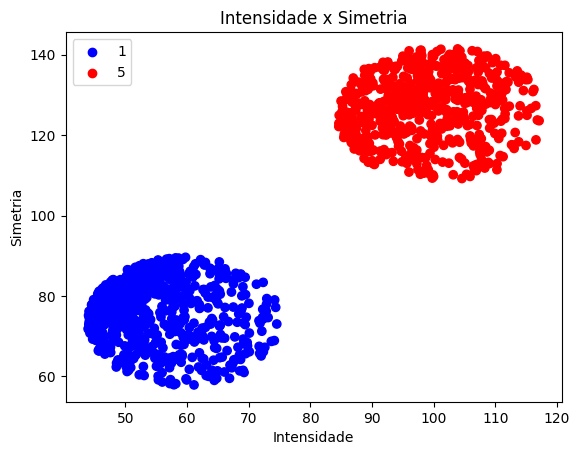

In [3]:
# Plotando o grafico intensidade x simetria do conjunto de treino
cores = {1: 'blue', 5: 'red'}
plt.scatter(dataframe_treino['intensidade'], dataframe_treino['simetria'], c=dataframe_treino['label'].map(cores))
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
for label, cor in cores.items():
    plt.scatter([], [], color=cor, label=label)
plt.legend()
plt.show()


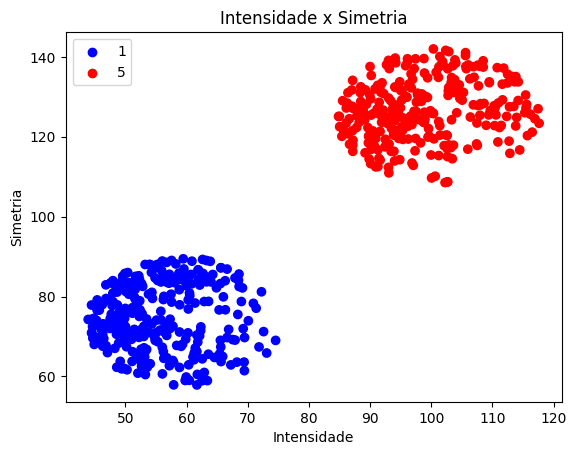

In [4]:
# Plotando o grafico intensidade x simetria do conjunto de teste
cores = {1: 'blue', 5: 'red'}

plt.scatter(dataframe_teste['intensidade'], dataframe_teste['simetria'], c=dataframe_teste['label'].map(cores))
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
for label, cor in cores.items():
    plt.scatter([], [], color=cor, label=label)
plt.legend()
plt.show()

### Tratamento dos dados

In [5]:
# Funçao para transformar os dados em uma normal 0,1
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = padronizar_normal(X)
X_teste = padronizar_normal(X_teste)
Y[Y == 1] = 1
Y[Y == 5] = -1
y_teste[y_teste == 1] = 1
y_teste[y_teste == 5] = -1

# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

In [63]:
def ver_confusao(matriz_de_confusao):
    plt.matshow(matriz_de_confusao, cmap='Blues')
    plt.title('Matriz de confusão')
    plt.colorbar()
    plt.ylabel("Classificações corretas")
    plt.xlabel("Classificações obtidas")
    plt.show()

In [65]:
def ver_treino(X, Y, a, b, modelo):
    # a e b são os dois indices escolhidos

    # Treinando o modelo de regressão linear
    #modelo.fit(X, Y)
    y_pred_treino = modelo.atribuicao_de_classes(X)

    #Criando a matriz de confusão
    matriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)
    print(matriz_de_confusao_treino)

    #Printando o relatório de classificação
    print(classification_report(Y, y_pred_treino, target_names=[str(a), str(b)]))

    # Voltando os valores de y_pred_treino_rl para 1 e 5
    y_pred_treino[y_pred_treino == 1] = a
    y_pred_treino[y_pred_treino == -1] = b

    # Criando a reta para plotar o gráfico
    w = modelo.getW()
    x = np.linspace(-2, 2, 100)
    y_plot = (-w[0] - w[1]*x) / w[2]
    # printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
    plt.scatter(X[y_pred_treino == a, 1], X[y_pred_treino == a, 2], color='blue', marker='o', label=a)
    plt.scatter(X[y_pred_treino == b, 1], X[y_pred_treino == b, 2], color='red', marker='o', label=b)
    plt.plot(x, y_plot, label=f'{modelo}')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    plt.title('Intensidade x Simetria')
    plt.legend()
    plt.show()
    ver_confusao(matriz_de_confusao_treino)



def ver_teste(X_teste, y_teste, a, b, modelo):
    y_pred_test = modelo.atribuicao_de_classes(X_teste)

    #Printando a matriz de confusao
    matriz_de_confusao_teste = confusion_matrix(y_teste, y_pred_test)
    print(matriz_de_confusao_teste)

    #Printando o relatório de classificação
    print(classification_report(y_teste, y_pred_test, target_names=[str(a), str(b)]))

    # Voltando os valores de y_pred_test_rl para 1 e 5
    y_pred_test[y_pred_test == 1] = a
    y_pred_test[y_pred_test == -1] = b

    w = modelo.getW()
    x = np.linspace(-2, 2, 100)
    y_plot = (-w[0] - w[1]*x) / w[2]
    # printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
    plt.scatter(X_teste[y_pred_test == a, 1], X_teste[y_pred_test == a, 2], color='blue', marker='o', label=a) # primeiro argumento é a intensidade, segundo é a simetria 
    plt.scatter(X_teste[y_pred_test == b, 1], X_teste[y_pred_test == b, 2], color='red', marker='o', label=b)
    plt.plot(x, y_plot, label=f'{modelo}')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    plt.title('Intensidade x Simetria')
    plt.legend()
    plt.show()
    ver_confusao(matriz_de_confusao_teste)

# Regressão Logística

### Criando o objeto e treinando o modelo de Regressão Logistica

Acuracia:  100.0
[[576   0]
 [  0 608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       576
           5       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



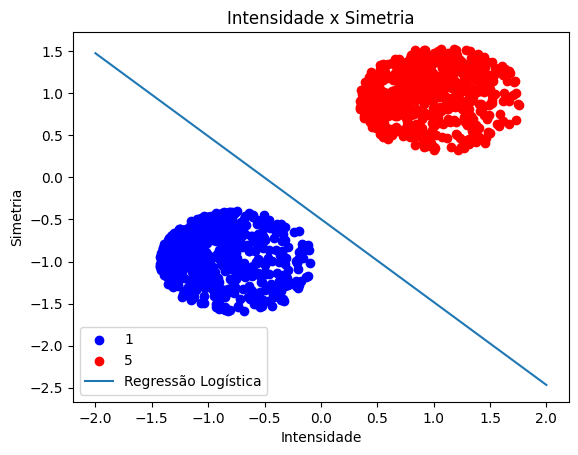

In [37]:
modelo = md.RegressaoLogistica()
w, acuracia, y_pred_treino = modelo.fit(X.T, Y) # Passo o X.transpose() para que a multiplicação de matrizes seja possível
print('Acuracia: ', acuracia)

#Criando a matriz de confusão
matriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)
print(matriz_de_confusao_treino)

#Printando o relatório de classificação
print(classification_report(Y, y_pred_treino, target_names=['1', '5']))

# Voltando os valores de y_pred_treino para 1 e 5
y_pred_treino[y_pred_treino == -1] = 5

# Criando a reta para plotar o gráfico
x = np.linspace(-2, 2, 100)
y_plot = (-w[0] - w[1]*x) / w[2]
# printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
plt.scatter(X[y_pred_treino == 1, 1], X[y_pred_treino == 1, 2], color='blue', marker='o', label='1')
plt.scatter(X[y_pred_treino == 5, 1], X[y_pred_treino == 5, 2], color='red', marker='o', label='5')
plt.plot(x, y_plot, label='Regressão Logística')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

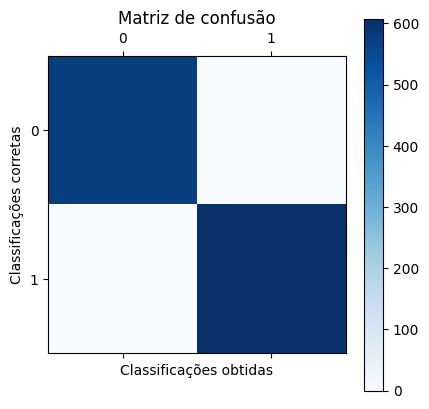

In [7]:
plt.matshow(matriz_de_confusao_treino, cmap='Blues')
plt.title('Matriz de confusão')
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

### Utilizando o w encontrado no treino para o teste (generalização)

Acuracia:  100.0
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       291
           5       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



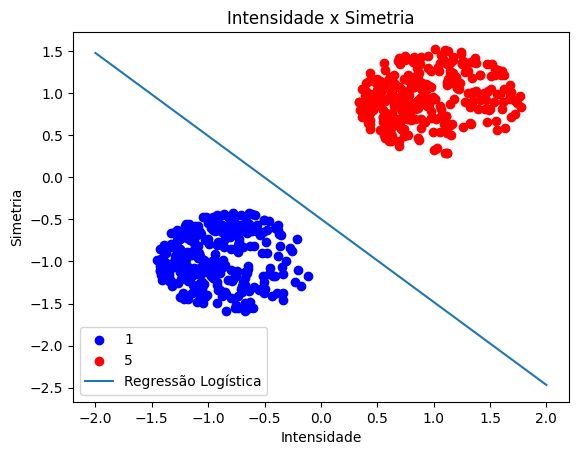

In [8]:
probabilidades = modelo.probabilidades(w, X_teste.T) # Passo o X.transpose() para que a multiplicação de matrizes seja possível e o w que foi obtido no treino
y_pred_test = modelo.atribuicao_de_classes(probabilidades)
print('Acuracia: ', modelo.calculate_accuracy(y_pred_test, y_teste))

#Printando a matriz de confusao
matriz_de_confusao_teste = confusion_matrix(y_teste, y_pred_test)
print(matriz_de_confusao_teste)
#Printando o relatório de classificação
print(classification_report(y_teste, y_pred_test, target_names=['1', '5']))

# Voltando os valores de y_pred_test para 1 e 5
y_pred_test[y_pred_test == -1] = 5

x = np.linspace(-2, 2, 100)
y_plot = (-w[0] - w[1]*x) / w[2]
# printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
plt.scatter(X_teste[y_pred_test == 1, 1], X_teste[y_pred_test == 1, 2], color='blue', marker='o', label='1') # primeiro argumento é a intensidade, segundo é a simetria 
plt.scatter(X_teste[y_pred_test == 5, 1], X_teste[y_pred_test == 5, 2], color='red', marker='o', label='5')
plt.plot(x, y_plot, label='Regressão Logística')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

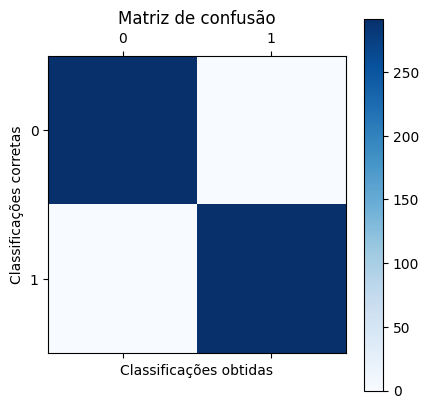

In [9]:
plt.matshow(matriz_de_confusao_teste, cmap='Blues')
plt.title('Matriz de confusão')
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

# Perceptron

Treino
[[576   0]
 [  0 608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       576
           5       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



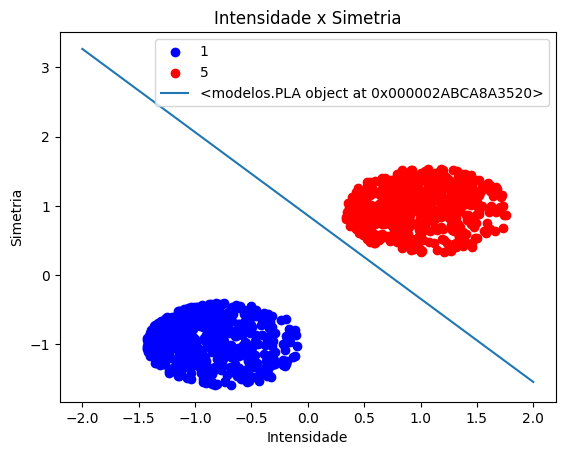

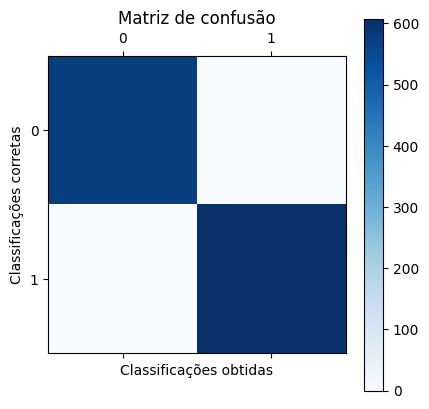

Teste
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       291
           5       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



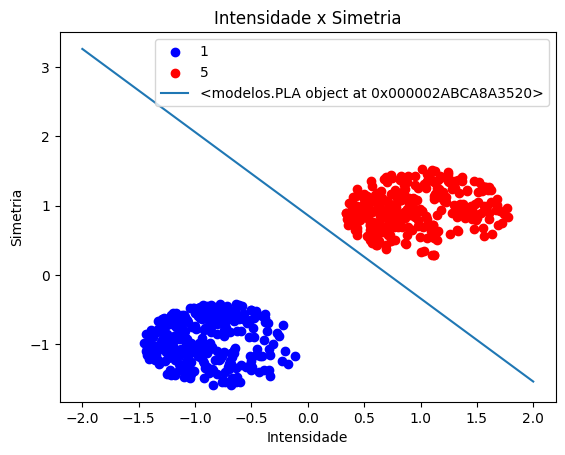

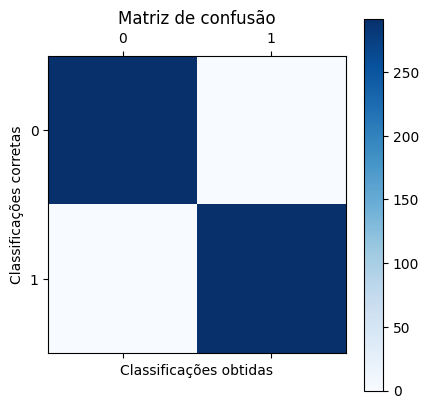

In [66]:
PLA = md.PLA()
PLA.fit(X, Y)

print("Treino")
ver_treino(X, Y, 1, 5, PLA)

print("Teste")
ver_teste(X_teste, y_teste, 1, 5, PLA)

# Regressão Linear

### Criando o objeto e treinando o modelo de Regressão Linear

Treino
[[576   0]
 [  0 608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       576
           5       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



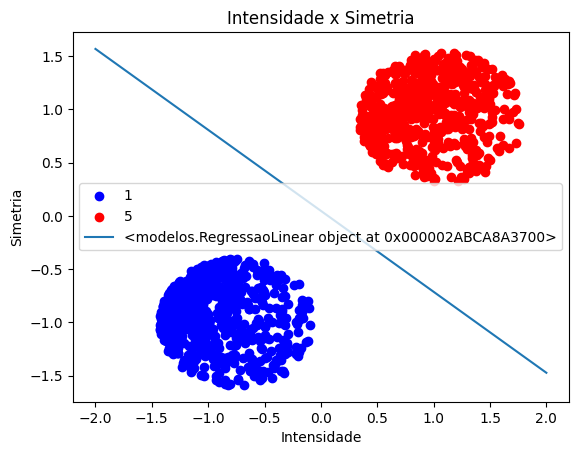

Teste
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       291
           5       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



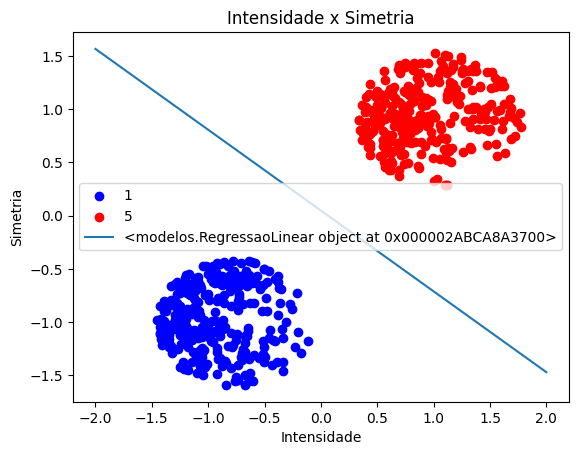

In [61]:
RL = md.RegressaoLinear()
RL.fit(X, Y)

print("Treino")
ver_treino(X, Y, 1, 5, RL)

print("Teste")
ver_teste(X_teste, y_teste, 1, 5, RL)

### Utilizando o w encontrado no treino para o teste (generalização)